# Style Transfer Using Convolutional Neural Networks

In this Jupyter Notebook, I have implemented a style transfer technique inspired by Gatys' paper [Image Style Transfer Using Convolutional Neural Networks](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf) using PyTorch.

The method outlined in the paper utilizes features from the 19-layer VGG Network, consisting of convolutional, pooling layers, and a few fully-connected layers. The convolutional layers are labeled by stack and their position in the stack, with Conv_1_1 being the first convolutional layer and conv_5_4 being the deepest in the network.

<img src='images/vgg19_convlayers.png' width=80% />

## Separating Style and Content

Style transfer involves isolating the content and style of an image. Given a content image and a style image, the goal is to create a new target image that combines the desired content and style:
- The arrangement of objects should resemble that of the **content image**.
- The style, colors, and textures should resemble those of the **style image**.

In this notebook, I will use a pre-trained VGG19 Net to extract content and style features from an input image. I will formalize the content and style losses and use them iteratively to update the target image until achieving the desired stylised result.

In [1]:
# Import necessary libraries
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
from torchvision import transforms, models

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Model Architecture 

In [4]:
# Load the VGG19 model with pre-trained weights and freeze its parameters
vgg = models.vgg19(weights=True).features

# Set requires_grad to False for all parameters, making them untrainable
for param in vgg.parameters():
    param.requires_grad_(False)
    
vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

## Data Preprocessing

This function loads an image from the specified file path, performs preprocessing, and returns it as a PyTorch tensor. It allows for resizing the image to a maximum size or a custom shape. The image is converted to RGB format, resized, transformed to a tensor, and normalized.

In [5]:
def load_image(img_path, max_size=400, shape=None):
    """
    Load and preprocess an image from the specified path.

    Parameters:
    - img_path (str): Path to the image file.
    - max_size (int): Maximum size for resizing the image to avoid slow processing.
    - shape (tuple): Target shape for resizing the image. If specified, overrides max_size.

    Returns:
    - torch.Tensor: Preprocessed image as a PyTorch tensor.
    """

    # Convert it to RGB format
    image = Image.open(img_path).convert('RGB')

    # Limit the size of large images
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)

    if shape is not None:
        size = shape

    # Defining the image transformation pipeline
    in_transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

    # Applying the transformation
    image = in_transform(image)[:3, :, :].unsqueeze(0)

    return image

In [6]:
# Load content and style images
content = load_image('images/ronit.jpg').to(device)
style = load_image('images/starry_night.jpg', shape=content.shape[-2:]).to(device)

The below function returns a NumPy array representing an input image. It involves cloning, detaching, moving to CPU, and reversing normalization to obtain pixel values in the correct range. The resulting NumPy array is suitable for display as an image.

In [7]:
def im_convert(tensor):
    """
    Convert a PyTorch tensor to a displayable image.

    Parameters:
    - tensor (torch.Tensor): Input tensor to be converted.

    Returns:
    - image (numpy.ndarray): Image representation of the tensor.
    """

    # Clone and detach the tensor, move to CPU
    image = tensor.to("cpu").clone().detach()

    # Convert tensor to a numpy array and rearrange dimensions
    image = image.numpy().squeeze()
    image = image.transpose(1, 2, 0)

    # Reverse normalization to obtain original pixel values
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))

    # Clip values to the valid range [0, 1]
    image = image.clip(0, 1)

    return image

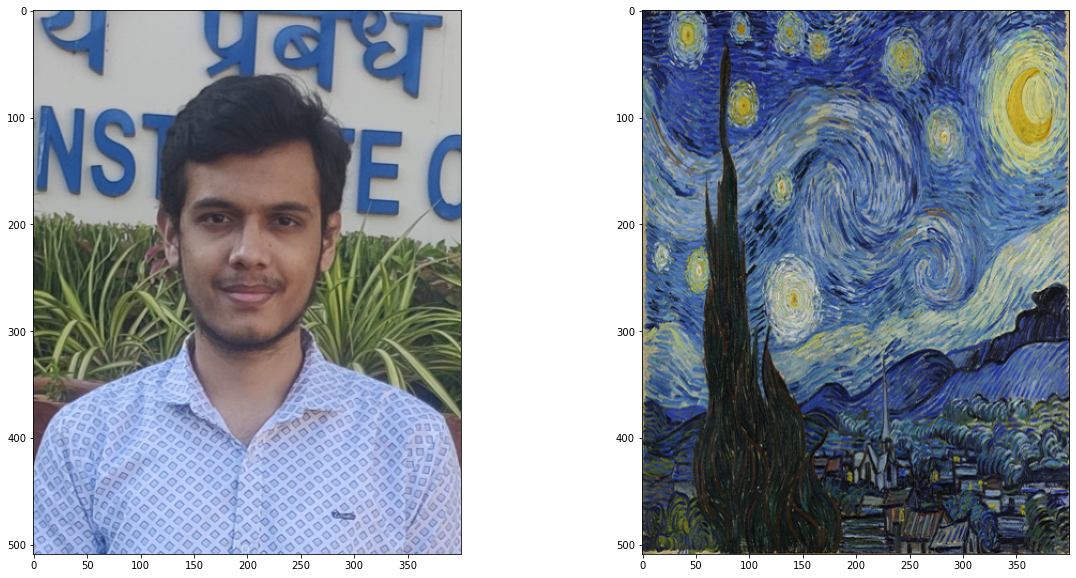

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style))

The function below runs the image forward through the model and extracts features for the specified layers. The default layers are set to match those used in Gatys et al. (2016) for content and style representations in VGGNet.

In [9]:
def extract_features(image, model, layers=None):
    """
    Extract features from an image by passing it through a deep learning model.

    Parameters:
    - image (torch.Tensor): Input image tensor.
    - model (torch.nn.Module): Deep learning model.
    - layers (dict): Mapping of layer indices to layer names. Default is for VGGNet.

    Returns:
    - features (dict): Extracted features for specified layers.
    """

    default_layers = {'0': 'conv1_1',
                      '5': 'conv2_1', 
                      '10': 'conv3_1', 
                      '19': 'conv4_1',
                      '21': 'conv4_2',  ## content representation
                      '28': 'conv5_1'}
    
    if layers is None:
        layers = default_layers
        
    # Dictionary to store extracted features
    features = {}
    x = image
    
    # Eextracting features for specified layers
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
            
    return features

The below function computes the Gram Matrix of a given feature map, a common operation in neural style transfer. The Gram Matrix is calculated by reshaping the input feature map, and then performing a matrix multiplication of the feature map with its transpose. The resulting Gram Matrix encapsulates the correlations between different features in the original feature map.

In [10]:
def calculate_gram_matrix(feature_map):
    """
    Compute the Gram Matrix of a given feature map.
    
    Parameters:
    - feature_map (torch.Tensor): Input feature map tensor.

    Returns:
    - gram_matrix (torch.Tensor): Computed Gram Matrix.
    """

    _, depth, height, width = feature_map.size()
    reshaped_feature_map = feature_map.view(depth, height * width)
    
    # Calculating the Gram Matrix by multiplying the feature map with its transpose
    gram_matrix = torch.mm(reshaped_feature_map, reshaped_feature_map.t())
    
    return gram_matrix

In [11]:
content_features = extract_features(content, vgg)
style_features = extract_features(style, vgg)

# Calculate the Gram matrices for each layer of the style representation
style_grams = {layer: calculate_gram_matrix(style_features[layer]) for layer in style_features}

target = content.clone().requires_grad_(True).to(device)

In [12]:
# Defining weights for each layer
style_weights = {
    'conv1_1': 1.0,
    'conv2_1': 0.75,
    'conv3_1': 0.2,
    'conv4_1': 0.2,
    'conv5_1': 0.2
}

# Setting weights for content and style contributions
content_weight = 1
style_weight = 1e5

## Training and Evaluation

Total loss at step 1000: 111931.3671875


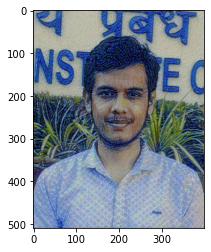

Total loss at step 2000: 38015.8359375


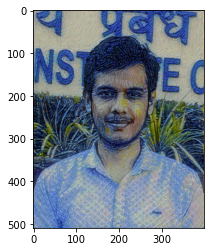

Total loss at step 3000: 17430.166015625


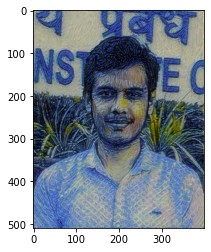

Total loss at step 4000: 9515.4580078125


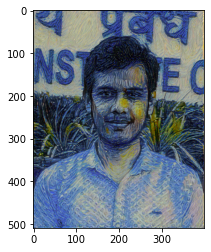

Total loss at step 5000: 6138.63525390625


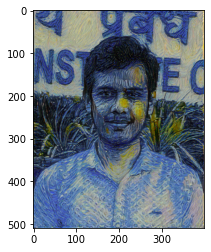

In [13]:
display_frequency = 1000
optimizer = optim.Adam([target], lr=0.01)
num_steps = 5000

# Optimisation loop
for step in range(1, num_steps+1):
    # Extract features from the target image
    target_features = extract_features(target, vgg)

    # Calculate content loss
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)

    # Initialize style loss
    style_loss = 0

    # Calculate style loss for each layer
    for layer, weight in style_weights.items():
        target_feature = target_features[layer]
        target_gram = calculate_gram_matrix(target_feature)
        _, depth, height, width = target_feature.shape
        style_gram = style_grams[layer]
        
        # Loss for the current layer
        layer_style_loss = weight * torch.mean((target_gram - style_gram)**2)
        style_loss += layer_style_loss / (depth * height * width)

    # Calculate total loss as a combination of content and style losses
    total_loss = content_weight * content_loss + style_weight * style_loss

    optimizer.zero_grad() # Optimisation steps
    total_loss.backward()
    optimizer.step()

    if step % display_frequency == 0:
        print('Total loss at step {}: {}'.format(step, total_loss.item()))
        plt.imshow(im_convert(target))
        plt.show()

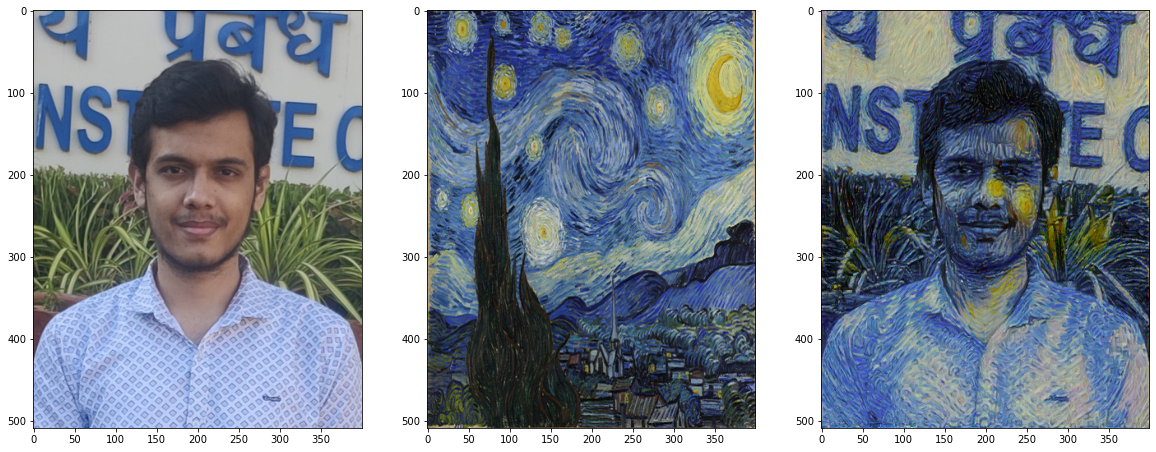

In [17]:
# Display content, style and final image
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style))
ax3.imshow(im_convert(target))